# Average Directional Index (ADX)

## • Coding Part

### 1. Importing necessary Libraries

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Reading the csv to a Pandas dataframe

In [2]:
data = pd.read_csv("stock_prices.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.785904,135480400
1,2020-01-03,74.287498,75.144997,74.125000,74.357498,73.068573,146322800
2,2020-01-06,73.447502,74.989998,73.187500,74.949997,73.650787,118387200
3,2020-01-07,74.959999,75.224998,74.370003,74.597504,73.304413,108872000
4,2020-01-08,74.290001,76.110001,74.290001,75.797501,74.483597,132079200


### 3. Defining functions for various calculations

In [3]:
def tr(db):
    db["TR"] = db.apply(lambda row: max(row.High-row.Low, abs(row.Close-row.Low), abs(row.Close-row.High)), axis=1)

In [4]:
def smooth(N, db, parameter): 
    db[f"A{parameter}"] = pd.NaT
    for i in range(len(db)):
        if i<N:
            db[f"A{parameter}"][i] = 0
        elif i==N:
            db[f"A{parameter}"][i] = (db[f"{parameter}"][0:i].sum())/N
        else:
            db[f"A{parameter}"][i] = ((N-1)*db[f"A{parameter}"][i-1] + db[f"{parameter}"][i])/N

In [5]:
def dmp(db):
    db["DM+"] = pd.NaT
    for i in range(len(db)):
        if i==0:
            db["DM+"][i] = 0
        else:
            db["DM+"][i] = max(db["High"][i]-db["High"][i-1], 0)

In [6]:
def dmm(db):
    db["DM-"] = pd.NaT
    for i in range(len(db)):
        if i==0:
            db["DM-"][i] = 0
        else:
            db["DM-"][i] = max(db["Low"][i-1]-db["Low"][i], 0)

In [7]:
def di(db):
    db["DI+"] = db.apply(lambda x: 100*x["ADM+"]/x["ATR"] if x["ATR"]!=0 else 0, axis=1)
    db["DI-"] = db.apply(lambda x: 100*x["ADM-"]/x["ATR"] if x["ATR"]!=0 else 0, axis=1)

In [8]:
def dx(db):
    db["DX"] = db.apply(lambda x: 100*(abs(x["DI+"]-x["DI-"])/abs(x["DI+"]+x["DI-"])) if x["ATR"]!=0 else 0, axis=1)

### 4. Defining a pipeline function to manage the flow and plot the graphs

In [9]:
def adx(N, db):
    tr(db)
    smooth(N, db, "TR")
    dmp(db)
    dmm(db)
    smooth(N, db, "DM+")
    smooth(N, db, "DM-")
    di(db)
    dx(db)
    smooth(N, db, "DX")
    
    fig = plt.figure(figsize=(30,8))
    price = plt.subplot(3, 1, (1, 2), ylabel="Close Price")
    price.axes.get_xaxis().set_visible(False)
    plt.plot(db["Date"][N:], db["Close"][N:])
    
    index = plt.subplot(3, 1, 3, sharex=price)
    plt.plot(db["Date"][N:], db["ADX"][N:],'k', label=f"{N}-day ADX")
    plt.plot(db["Date"][N:], db["DI+"][N:],'g', label=f"{N}-day DI+")
    plt.plot(db["Date"][N:], db["DI-"][N:],'r', label=f"{N}-day DI-")
    plt.legend(loc=1)
    index.axes.get_xaxis().set_visible(False)
    
    plt.savefig(f"{N}-day ADX.jpeg",bbox_inches='tight')
    plt.show()

### 5. Calling the pipeline function

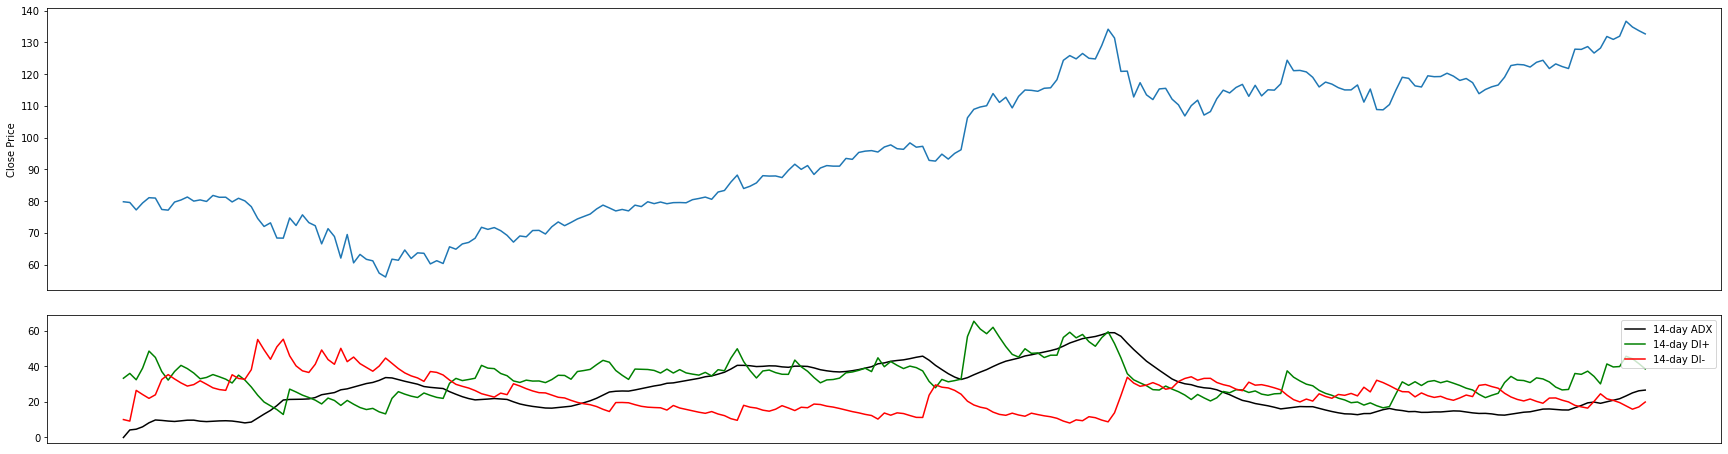

,Date,Open,High,Low,Close,Adj Close,Volume,TR,ATR,DM+,DM-,ADM+,ADM-,DI+,DI-,DX,ADX
248,2020-12-24,131.320007,133.460007,131.100006,131.970001,130.802322,54930100,2.360001,2.840847,1.030014,0,1.132947,0.557331,39.880586,19.618474,34.054508,21.788079
249,2020-12-28,133.990005,137.339996,133.509995,136.690002,135.480591,124486200,3.830002,2.911501,3.87999,0,1.329164,0.517522,45.652185,17.775076,43.951305,23.371166
250,2020-12-29,138.050003,138.789993,134.339996,134.869995,133.676682,121047300,4.449997,3.021394,1.449997,0,1.337795,0.480556,44.277408,15.905101,47.143776,25.06921
251,2020-12-30,135.580002,135.990005,133.399994,133.720001,132.536850,96452100,2.590012,2.990581,0,0.940002,1.242238,0.513373,41.538356,17.166343,41.516290,26.244001
252,2020-12-31,134.080002,134.740005,131.720001,132.690002,131.515976,99116600,3.020004,2.992683,0,1.679993,1.153507,0.596703,38.544243,19.938744,31.813523,26.641824


In [10]:
adx(14, data)
data.tail()

## • Insights about the ADX Indicator

1. It is a trend strength measuring indicator.
2. Higher values of the indicator imply a definite trend.
3. Lower values of the indicator imply an ambiguous trend, both stagnant as well as over-volatile conditions.
4. According to Welles Wilder(the designer of the index), a trend is said to be strong when the $\text{ADX}>25$, and is said to be weak when $\text{ATX}<20$.
5. The supporting indicators $\text{+DI}$ and $\text{-DI}$ also assist in determing the buy and sell pressure in the market respectively.

## • A Potential Trading Strategy

1. Only enter trades when $\text{ATX}>25$.
2. If the $\text{+DI}$ surpasses the $\text{-DI}$, take a long position. This is because an increasing $\text{+DI}$ implies a bullish trend.
3. Conversely if the $\text{-DI}$ surpasses the $\text{+DI}$, take a short position. This is because an increasing $\text{-DI}$ implies a bearish trend.